In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import io
import typing
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import PIL
import keras
from keras import layers
from keras import ops

2025-10-31 09:11:41.452022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = self.add_weight(
            shape=(projection_dim,),
            initializer=keras.initializers.Constant(init_values),
        )

    def call(self, x, training=False):
        return x * self.gamma

In [3]:
class StochasticDepth(layers.Layer):
    """Stochastic Depth layer (https://arxiv.org/abs/1603.09382).

    Reference:
        https://github.com/rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob: float, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + ops.random.uniform(
                shape, minval=0, maxval=1, seed=self.seed_generator
            )
            random_tensor = ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [4]:
class ClassAttention(layers.Layer):
    """Class attention as proposed in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads

        head_dim = projection_dim // num_heads
        self.scale = head_dim**-0.5

        self.q = layers.Dense(projection_dim)
        self.k = layers.Dense(projection_dim)
        self.v = layers.Dense(projection_dim)
        self.attn_drop = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(projection_dim)
        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        batch_size, num_patches, num_channels = (
            ops.shape(x)[0],
            ops.shape(x)[1],
            ops.shape(x)[2],
        )

        # Query projection. `cls_token` embeddings are queries.
        q = ops.expand_dims(self.q(x[:, 0]), axis=1)
        q = ops.reshape(
            q, (batch_size, 1, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, 1, num_heads, dimension_per_head)
        q = ops.transpose(q, axes=[0, 2, 1, 3])
        scale = ops.cast(self.scale, dtype=q.dtype)
        q = q * scale

        # Key projection. Patch embeddings as well the cls embedding are used as keys.
        k = self.k(x)
        k = ops.reshape(
            k, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, num_tokens, num_heads, dimension_per_head)
        k = ops.transpose(k, axes=[0, 2, 3, 1])

        # Value projection. Patch embeddings as well the cls embedding are used as values.
        v = self.v(x)
        v = ops.reshape(
            v, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )
        v = ops.transpose(v, axes=[0, 2, 1, 3])

        # Calculate attention scores between cls_token embedding and patch embeddings.
        attn = ops.matmul(q, k)
        attn = ops.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training=training)

        x_cls = ops.matmul(attn, v)
        x_cls = ops.transpose(x_cls, axes=[0, 2, 1, 3])
        x_cls = ops.reshape(x_cls, (batch_size, 1, num_channels))
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls, training=training)

        return x_cls, attn

In [5]:
class TalkingHeadAttention(layers.Layer):
    """Talking-head attention as proposed in CaiT: https://arxiv.org/abs/2003.02436.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)

        self.num_heads = num_heads

        head_dim = projection_dim // self.num_heads

        self.scale = head_dim**-0.5

        self.qkv = layers.Dense(projection_dim * 3)
        self.attn_drop = layers.Dropout(dropout_rate)

        self.proj = layers.Dense(projection_dim)

        self.proj_l = layers.Dense(self.num_heads)
        self.proj_w = layers.Dense(self.num_heads)

        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        B, N, C = ops.shape(x)[0], ops.shape(x)[1], ops.shape(x)[2]

        # Project the inputs all at once.
        qkv = self.qkv(x)

        # Reshape the projected output so that they're segregated in terms of
        # query, key, and value projections.
        qkv = ops.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))

        # Transpose so that the `num_heads` becomes the leading dimensions.
        # Helps to better segregate the representation sub-spaces.
        qkv = ops.transpose(qkv, axes=[2, 0, 3, 1, 4])
        scale = ops.cast(self.scale, dtype=qkv.dtype)
        q, k, v = qkv[0] * scale, qkv[1], qkv[2]

        # Obtain the raw attention scores.
        attn = ops.matmul(q, ops.transpose(k, axes=[0, 1, 3, 2]))

        # Linear projection of the similarities between the query and key projections.
        attn = self.proj_l(ops.transpose(attn, axes=[0, 2, 3, 1]))

        # Normalize the attention scores.
        attn = ops.transpose(attn, axes=[0, 3, 1, 2])
        attn = ops.nn.softmax(attn, axis=-1)

        # Linear projection on the softmaxed scores.
        attn = self.proj_w(ops.transpose(attn, axes=[0, 2, 3, 1]))
        attn = ops.transpose(attn, axes=[0, 3, 1, 2])
        attn = self.attn_drop(attn, training=training)

        # Final set of projections as done in the vanilla attention mechanism.
        x = ops.matmul(attn, v)
        x = ops.transpose(x, axes=[0, 2, 1, 3])
        x = ops.reshape(x, (B, N, C))

        x = self.proj(x)
        x = self.proj_drop(x, training=training)

        return x, attn

In [6]:
def mlp(x, dropout_rate: float, hidden_units: typing.List[int]):
    """FFN for a Transformer block."""
    for idx, units in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=ops.nn.gelu if idx == 0 else None,
            bias_initializer=keras.initializers.RandomNormal(stddev=1e-6),
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
def LayerScaleBlockClassAttention(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    cls token and the embeddings of image patches.

    Includes LayerScale and Stochastic Depth.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    x = keras.Input((None, projection_dim))
    x_cls = keras.Input((None, projection_dim))
    inputs = keras.layers.Concatenate(axis=1)([x_cls, x])

    # Class attention (CA).
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(inputs)
    attn_output, attn_scores = ClassAttention(projection_dim, num_heads, dropout_rate)(
        x1
    )
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = keras.layers.Add()([x_cls, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = keras.layers.Add()([x2, x4])

    return keras.Model([x, x_cls], [outputs, attn_scores], name=name)


def LayerScaleBlock(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    image patches.

    Includes LayerScale and Stochastic Depth.

        Args:
            projection_dim (int): projection dimension to be used in the
                Transformer blocks and patch projection layer.
            num_heads (int): number of attention heads.
            layer_norm_eps (float): epsilon to be used for Layer Normalization.
            init_values (float): initial value for the diagonal matrix used in LayerScale.
            mlp_units (List[int]): dimensions of the feed-forward network used in
                the Transformer blocks.
            dropout_rate (float): dropout rate to be used for dropout in the attention
                scores as well as the final projected outputs.
            sd_prob (float): stochastic depth rate.
            name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    encoded_patches = keras.Input((None, projection_dim))

    # Self-attention.
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    attn_output, attn_scores = TalkingHeadAttention(
        projection_dim, num_heads, dropout_rate
    )(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = layers.Add()([encoded_patches, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, [outputs, attn_scores], name=name)

In [8]:
class CaiT(keras.Model):
    """CaiT model.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        patch_size (int): patch size of the input images.
        num_patches (int): number of patches after extracting the image patches.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units: (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        sa_ffn_layers (int): number of self-attention Transformer blocks.
        ca_ffn_layers (int): number of class-attention Transformer blocks.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        global_pool (str): denotes how to pool the representations coming out of
            the final Transformer block.
        pre_logits (bool): if set to True then don't add a classification head.
        num_classes (int): number of classes to construct the final classification
            layer with.
    """

    def __init__(
        self,
        projection_dim: int,
        patch_size: int,
        num_patches: int,
        init_values: float,
        mlp_units: typing.List[int],
        sa_ffn_layers: int,
        ca_ffn_layers: int,
        num_heads: int,
        layer_norm_eps: float,
        dropout_rate: float,
        sd_prob: float,
        global_pool: str,
        pre_logits: bool,
        num_classes: int,
        **kwargs,
    ):
        if global_pool not in ["token", "avg"]:
            raise ValueError(
                'Invalid value received for `global_pool`, should be either `"token"` or `"avg"`.'
            )

        super().__init__(**kwargs)

        # Responsible for patchifying the input images and the linearly projecting them.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=projection_dim,
                    kernel_size=(patch_size, patch_size),
                    strides=(patch_size, patch_size),
                    padding="VALID",
                    name="conv_projection",
                    kernel_initializer="lecun_normal",
                ),
                layers.Reshape(
                    target_shape=(-1, projection_dim),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # CLS token and the positional embeddings.
        self.cls_token = self.add_weight(
            shape=(1, 1, projection_dim), initializer="zeros"
        )
        self.pos_embed = self.add_weight(
            shape=(1, num_patches, projection_dim), initializer="zeros"
        )

        # Projection dropout.
        self.pos_drop = layers.Dropout(dropout_rate, name="projection_dropout")

        # Stochastic depth schedule.
        dpr = [sd_prob for _ in range(sa_ffn_layers)]

        # Self-attention (SA) Transformer blocks operating only on the image patch
        # embeddings.
        self.blocks = [
            LayerScaleBlock(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                sd_prob=dpr[i],
                name=f"sa_ffn_block_{i}",
            )
            for i in range(sa_ffn_layers)
        ]

        # Class Attention (CA) Transformer blocks operating on the CLS token and image patch
        # embeddings.
        self.blocks_token_only = [
            LayerScaleBlockClassAttention(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                name=f"ca_ffn_block_{i}",
                sd_prob=0.0,  # No Stochastic Depth in the class attention layers.
            )
            for i in range(ca_ffn_layers)
        ]

        # Pre-classification layer normalization.
        self.norm = layers.LayerNormalization(epsilon=layer_norm_eps, name="head_norm")

        # Representation pooling for classification head.
        self.global_pool = global_pool

        # Classification head.
        self.pre_logits = pre_logits
        self.num_classes = num_classes
        if not pre_logits:
            self.head = layers.Dense(num_classes, name="classification_head")

    def call(self, x, training=False):
        # Notice how CLS token is not added here.
        x = self.projection(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # SA+FFN layers.
        sa_ffn_attn = {}
        for blk in self.blocks:
            x, attn_scores = blk(x)
            sa_ffn_attn[f"{blk.name}_att"] = attn_scores

        # CA+FFN layers.
        ca_ffn_attn = {}
        cls_tokens = ops.tile(self.cls_token, (ops.shape(x)[0], 1, 1))
        for blk in self.blocks_token_only:
            cls_tokens, attn_scores = blk([x, cls_tokens])
            ca_ffn_attn[f"{blk.name}_att"] = attn_scores

        x = ops.concatenate([cls_tokens, x], axis=1)
        x = self.norm(x)

        # Always return the attention scores from the SA+FFN and CA+FFN layers
        # for convenience.
        if self.global_pool:
            x = (
                ops.reduce_mean(x[:, 1:], axis=1)
                if self.global_pool == "avg"
                else x[:, 0]
            )
        return (
            (x, sa_ffn_attn, ca_ffn_attn)
            if self.pre_logits
            else (self.head(x), sa_ffn_attn, ca_ffn_attn)
        )

In [9]:
def get_config(
    image_size: int = 224,
    patch_size: int = 16,
    projection_dim: int = 192,
    sa_ffn_layers: int = 24,
    ca_ffn_layers: int = 2,
    num_heads: int = 4,
    mlp_ratio: int = 4,
    layer_norm_eps=1e-6,
    init_values: float = 1e-5,
    dropout_rate: float = 0.0,
    sd_prob: float = 0.0,
    global_pool: str = "token",
    pre_logits: bool = False,
    num_classes: int = 1000,
) -> typing.Dict:
    """Default configuration for CaiT models (cait_xxs24_224).

    Reference:
        https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/cait.py
    """
    config = {}

    # Patchification and projection.
    config["patch_size"] = patch_size
    config["num_patches"] = (image_size // patch_size) ** 2

    # LayerScale.
    config["init_values"] = init_values

    # Dropout and Stochastic Depth.
    config["dropout_rate"] = dropout_rate
    config["sd_prob"] = sd_prob

    # Shared across different blocks and layers.
    config["layer_norm_eps"] = layer_norm_eps
    config["projection_dim"] = projection_dim
    config["mlp_units"] = [
        projection_dim * mlp_ratio,
        projection_dim,
    ]

    # Attention layers.
    config["num_heads"] = num_heads
    config["sa_ffn_layers"] = sa_ffn_layers
    config["ca_ffn_layers"] = ca_ffn_layers

    # Representation pooling and task specific parameters.
    config["global_pool"] = global_pool
    config["pre_logits"] = pre_logits
    config["num_classes"] = num_classes

    return config

In [10]:
image_size = 224
num_channels = 3
batch_size = 2

config = get_config()
cait_xxs24_224 = CaiT(**config)

dummy_inputs = ops.ones((batch_size, image_size, image_size, num_channels))
_ = cait_xxs24_224(dummy_inputs)

I0000 00:00:1761898429.582091   10331 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8950 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2025-10-31 09:13:53.596448: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


In [15]:
import kagglehub

model_gcs_path = kagglehub.model_download("spsayakpaul/cait/tensorFlow2/xxs24-224")
pretrained_model = keras.Sequential(
    [keras.layers.TFSMLayer(model_gcs_path, call_endpoint="serving_default")]
)


  0%|                                                | 0.00/442k [00:00<?, ?B/s]



  0%|                                               | 0.00/25.9k [00:00<?, ?B/s]




100%|███████████████████████████████████████| 25.9k/25.9k [00:00<00:00, 397kB/s]




  0%|                                               | 0.00/45.8M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 442k/442k [00:00<00:00, 1.01MB/s]



  6%|██▏                                   | 1.00M/17.9M [00:00<00:10, 1.75MB/s]

  2%|▊                                     | 1.00M/45.8M [00:00<00:25, 1.84MB/s]


 11%|████▎                                 | 2.00M/17.9M [00:00<00:04, 3.40MB/s]

  7%|██▍                                   | 3.00M/45.8M [00:00<00:08, 5.09MB/s]


 22%|████████▌                             | 4.00M/17.9M [00:00<00:02, 7.08MB/s]

  9%|███▎                                  | 4.00M/45.8M [00:00<00:07, 5.62MB/s]


 34%|████████████▊                         | 6.00M/17.9M [00:01<00:01, 7.76MB/s]

 11%|████▏                                 | 5.00M/45.8M [00:00<00:06, 6.53MB/s]


 50%|███████████████████▏                  | 9.00M/17.9M [00:01<00:00, 11.6MB/s]

 15%|█████▊                                | 7.00M/45.8M [00:01<00:04, 9.02MB/s]


 67%|██

In [35]:
# The preprocessing transformations include center cropping, and normalizing
# the pixel values with the ImageNet-1k training stats (mean and standard deviation).
crop_layer = keras.layers.CenterCrop(image_size, image_size)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=image_size):
    image = np.array(image)
    image_resized = ops.expand_dims(image, 0)
    resize_size = int((256 / image_size) * size)
    image_resized = ops.image.resize(
        image_resized, (resize_size, resize_size), interpolation="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


#def load_image_from_url(url):
    #image_bytes = io.BytesIO(urlopen(url).read())
    #image = PIL.Image.open(image_bytes)
    #preprocessed_image = preprocess_image(image)
    #return image, preprocessed_image

In [37]:
# ImageNet-1k class labels.
imagenet_labels = (
    "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)
label_path = keras.utils.get_file(origin=imagenet_labels)

with open(label_path, "r") as f:
    lines = f.readlines()
imagenet_labels = [line.rstrip() for line in lines]

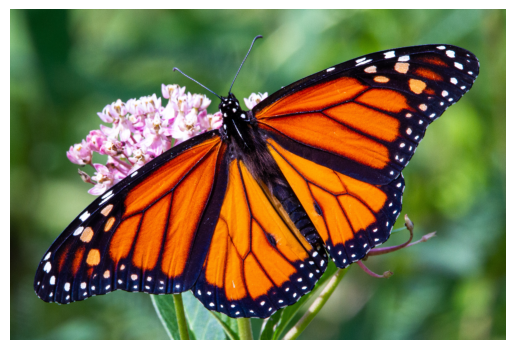

In [41]:
#img_location = "ErgfLTn.jpeg"
image = mpimg.imread('ErgfLTn.jpeg')

# https://unsplash.com/photos/Ho93gVTRWW8
plt.imshow(image)
plt.axis("off")
plt.show()


In [42]:
outputs = pretrained_model.predict(preprocessed_image)
logits = outputs["output_1"]
ca_ffn_block_0_att = outputs["output_3_ca_ffn_block_0_att"]
ca_ffn_block_1_att = outputs["output_3_ca_ffn_block_1_att"]

predicted_label = imagenet_labels[int(np.argmax(logits))]
print(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
web_site, website, internet_site, site


In [43]:
# (batch_size, nb_attention_heads, num_cls_token, seq_length)
print("Shape of the attention scores from a class attention block:")
print(ca_ffn_block_0_att.shape)

Shape of the attention scores from a class attention block:
(1, 4, 1, 197)


In [44]:
# Reference:
# https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

patch_size = 16


def get_cls_attention_map(
    attention_scores,
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attention_scores: the attention scores from the attention block to
            visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = ops.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        interpolation="bicubic",
    )

    return attentions

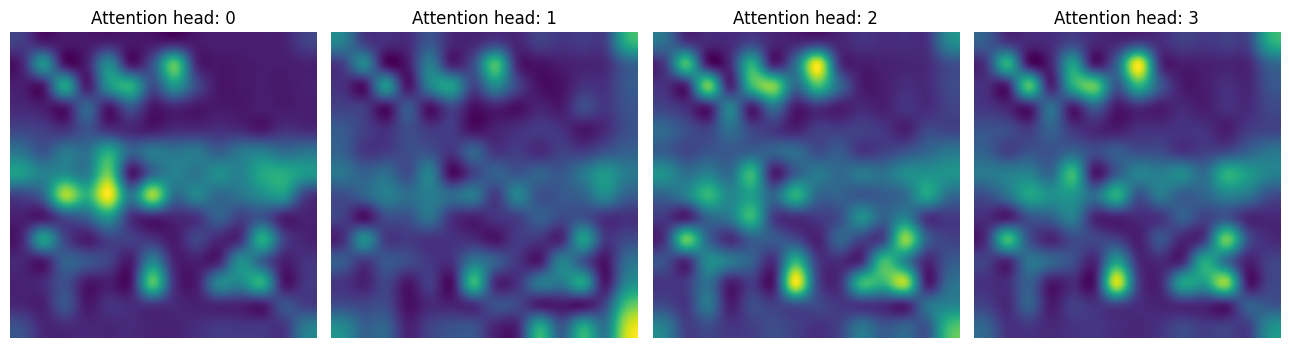

In [45]:
attentions_ca_block_0 = get_cls_attention_map(ca_ffn_block_0_att)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

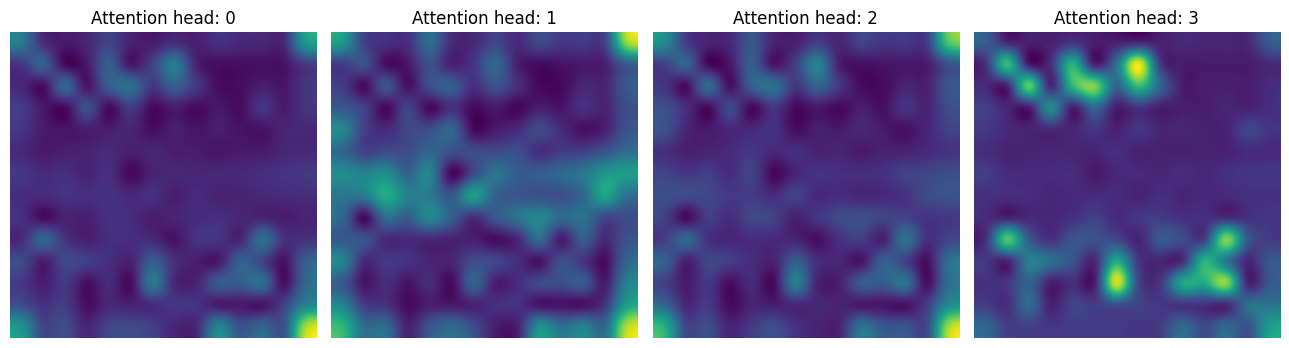

In [46]:
attentions_ca_block_1 = get_cls_attention_map(ca_ffn_block_1_att)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_1.shape[-1]):
    if img_count < attentions_ca_block_1.shape[-1]:
        axes[i].imshow(attentions_ca_block_1[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

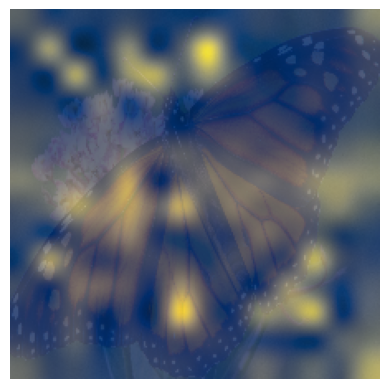

In [47]:
saliency_attention = get_cls_attention_map(ca_ffn_block_0_att, return_saliency=True)

image = np.array(image)
image_resized = ops.expand_dims(image, 0)
resize_size = int((256 / 224) * image_size)
image_resized = ops.image.resize(
    image_resized, (resize_size, resize_size), interpolation="bicubic"
)
image_resized = crop_layer(image_resized)

plt.imshow(image_resized.numpy().squeeze().astype("int32"))
plt.imshow(saliency_attention.numpy().squeeze(), cmap="cividis", alpha=0.9)
plt.axis("off")

plt.show()